In [1]:
import logging
from piny import YamlLoader
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
sys.path.append("../src")

In [3]:
from utils import setup_logging
from data.loader.football_data import FootballData
from data.feature import EloRatingGenerator, WinStreakGenerator, GapRatingGenerator, PiRatingGenerator, OverUnderGenerator
from models.classifier_comparison import ClassifierComparison
from strategy import KellyCriterionStrategy, FixedFractionalStrategy, FractionalKellyCriterionStrategy, ConfidenceThresholdStrategy, DynamicFractionalKellyCriterionStrategy

### Setting up Environment 

In [4]:
print("Loading config file...")
config = YamlLoader(path="../src/config/config.yaml").load()
FOOTBALL_DATA_CONFIG = config["data"]
COLUMNS = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA']

print("Loading football data...")
football_dataset = FootballData.load(**FOOTBALL_DATA_CONFIG, columns=COLUMNS)

Loading config file...
Loading football data...


/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_str, fmt)
/Users/charaka/Desktop/Projects/football-ml-betting/notebooks/../src/utils.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future ver

In [46]:
football_dataset.divisions["E0"].dataframe.head(2)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HS,...,B365A_prob,average_odds,odds_difference,prob_bin,BWH_prob,IWH_prob,BWD_prob,IWD_prob,BWA_prob,IWA_prob
0,E0,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,11,...,0.243243,2.00,0.00,30-40%,0.500000,0.47619,0.303030,0.303030,0.270270,0.303030
1,E0,2015-08-08,Chelsea,Swansea,2,2,D,2,1,11,...,0.088588,1.38,-0.04,10-20%,0.714286,0.75188,0.210526,0.208333,0.111111,0.120482


## Frequency Matching
Compare the implied probabilities from the odds to the actual outcomes over a long period.

In [37]:
class BookmakerOdds:
    def __init__(self, data, bookmaker, outcomes):
        self.data = data
        self.bookmaker = bookmaker
        self.outcomes = outcomes

    def calculate_implied_probabilities(self):
        # First, calculate the raw implied probabilities
        for outcome in self.outcomes:
            odds_column = f"{self.bookmaker}{outcome}"
            prob_column = f"{odds_column}_prob"
            self.data[prob_column] = 1 / self.data[odds_column]
        
        # Calculate the total implied probability for all outcomes combined
        total_implied_probability = self.data[[f"{self.bookmaker}{outcome}_prob" for outcome in self.outcomes]].sum(axis=1)
        
        # Adjust for over-round by distributing the excess proportionally
        over_round = total_implied_probability - 1
        adjustment_factors = over_round / total_implied_probability
        for outcome in self.outcomes:
            prob_column = f"{self.bookmaker}{outcome}_prob"
            self.data[prob_column] -= adjustment_factors * self.data[prob_column]

    def get_average_implied_probabilities(self):
        return [self.data[f"{self.bookmaker}{outcome}_prob"].mean() for outcome in self.outcomes]

def get_observed_probabilities(data, outcomes):
    return [(data['FTR'] == outcome).mean() for outcome in outcomes]

In [49]:
data = football_dataset.divisions['E0'].dataframe
bookmakers = ['B365', 'BW', 'IW']
outcomes = ['H', 'D', 'A']
bookmaker_odds = {}

for bookmaker_name in bookmakers:
    bookmaker = BookmakerOdds(data, bookmaker_name, outcomes)
    bookmaker.calculate_implied_probabilities()
    bookmaker_odds[bookmaker_name] = bookmaker

In [57]:
for bookmaker_name in bookmaker_odds.keys():
    print(f"{bookmaker_name}: {bookmaker_odds[bookmaker_name].get_average_implied_probabilities()}")

print(f"Actual: {get_observed_probabilities(data, outcomes)}")

B365: [0.4400539597804455, 0.24278629161046625, 0.31715974860908824]
BW: [0.4378469842550389, 0.24433569819848014, 0.31781731754648107]
IW: [0.43523831542559427, 0.2462939633732407, 0.31846772120116507]
Actual: [0.44784468575189207, 0.23395853899308983, 0.3181967752550181]


## Long-Term ROI
Calculate the ROI if one were to bet $1 on every match using the `B365` odds:

In [32]:
# Define a function to calculate ROI based on bets and outcomes
def calculate_roi(bookie, outcome_column, data):
    odds_column = bookie + outcome_column
    # Calculate potential returns (including the original stake)
    returns = data[data['FTR'] == outcome_column][odds_column]

    # Total amount bet is simply the number of matches (assuming $1 bet per match)
    total_bet = len(data)
    
    # Total return is the sum of returns for winning bets
    total_return = returns.sum()

    # ROI is (total return - total bet) / total bet
    roi = (total_return - total_bet) / total_bet

    return roi

In [33]:
# Calculate ROI for betting on home win, draw, and away win based on B365 odds
roi_home = calculate_roi('B365', 'H', data)
roi_draw = calculate_roi('B365', 'D', data)
roi_away = calculate_roi('B365', 'A', data)

roi_home, roi_draw, roi_away


(-0.010723922342875994, -0.07914445541296479, -0.03269825600526485)

## Bland-Altman plot

Visualize any systematic differences between the two sets of odds from differnet bookmakers and to see if there are any trends or biases in the discrepancies.

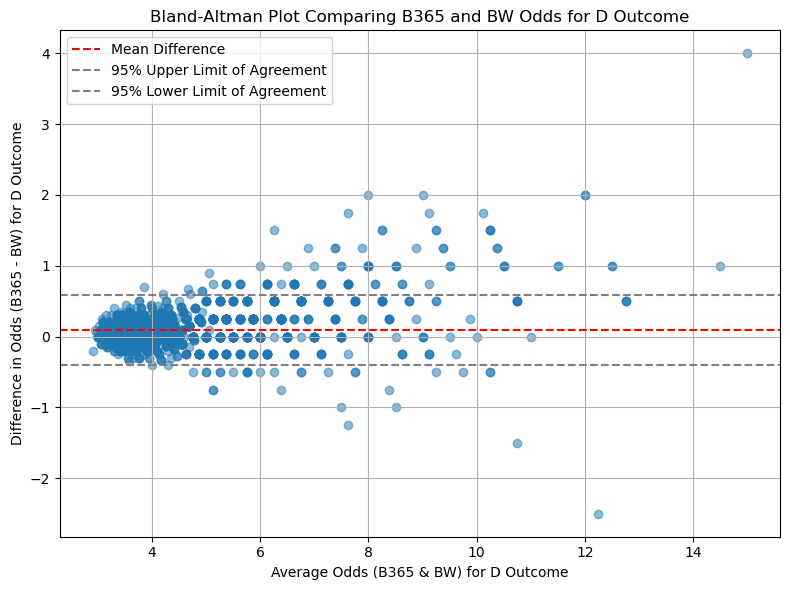

In [60]:
import matplotlib.pyplot as plt

class BlandAltman:
    def __init__(self, data, bookmaker1, bookmaker2, outcome):
        self.data = data
        self.bookmaker1 = bookmaker1
        self.bookmaker2 = bookmaker2
        self.outcome = outcome
        self.average_odds_col = f"average_{bookmaker1}_{bookmaker2}_{outcome}_odds"
        self.odds_difference_col = f"{bookmaker1}_{bookmaker2}_{outcome}_odds_difference"

    def calculate_average_and_difference(self):
        odds1_col = f"{self.bookmaker1}{self.outcome}"
        odds2_col = f"{self.bookmaker2}{self.outcome}"
        self.data[self.average_odds_col] = (self.data[odds1_col] + self.data[odds2_col]) / 2
        self.data[self.odds_difference_col] = self.data[odds1_col] - self.data[odds2_col]

    def bland_altman_plot(self):
        # Calculate the mean difference and the 95% limits of agreement
        mean_difference = self.data[self.odds_difference_col].mean()
        std_difference = self.data[self.odds_difference_col].std()
        upper_limit = mean_difference + 1.96 * std_difference
        lower_limit = mean_difference - 1.96 * std_difference

        # Create the Bland-Altman plot
        plt.figure(figsize=(8, 6))
        plt.scatter(self.data[self.average_odds_col], self.data[self.odds_difference_col], alpha=0.5)
        plt.axhline(mean_difference, color='red', linestyle='--', label='Mean Difference')
        plt.axhline(upper_limit, color='grey', linestyle='--', label='95% Upper Limit of Agreement')
        plt.axhline(lower_limit, color='grey', linestyle='--', label='95% Lower Limit of Agreement')
        plt.xlabel(f'Average Odds ({self.bookmaker1} & {self.bookmaker2}) for {self.outcome} Outcome')
        plt.ylabel(f'Difference in Odds ({self.bookmaker1} - {self.bookmaker2}) for {self.outcome} Outcome')
        plt.title(f'Bland-Altman Plot Comparing {self.bookmaker1} and {self.bookmaker2} Odds for {self.outcome} Outcome')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Testing the refactored code
ba_analysis = BlandAltman(data, 'B365', 'BW', 'D')
ba_analysis.calculate_average_and_difference()
ba_analysis.bland_altman_plot()


## Calibration Plots
This involves binning matches based on their implied probabilities (e.g., 0-10%, 10-20%, ...) and then calculating the actual win percentage for each bin. If the implied probabilities are well-calibrated, the actual win percentage should closely match the implied probabilities for each bin.

- The blue line represents the actual win percentage for each bin of implied probabilities
- The red dashed line represents perfect calibration, where the implied probabilities would match the actual outcomes exactly.

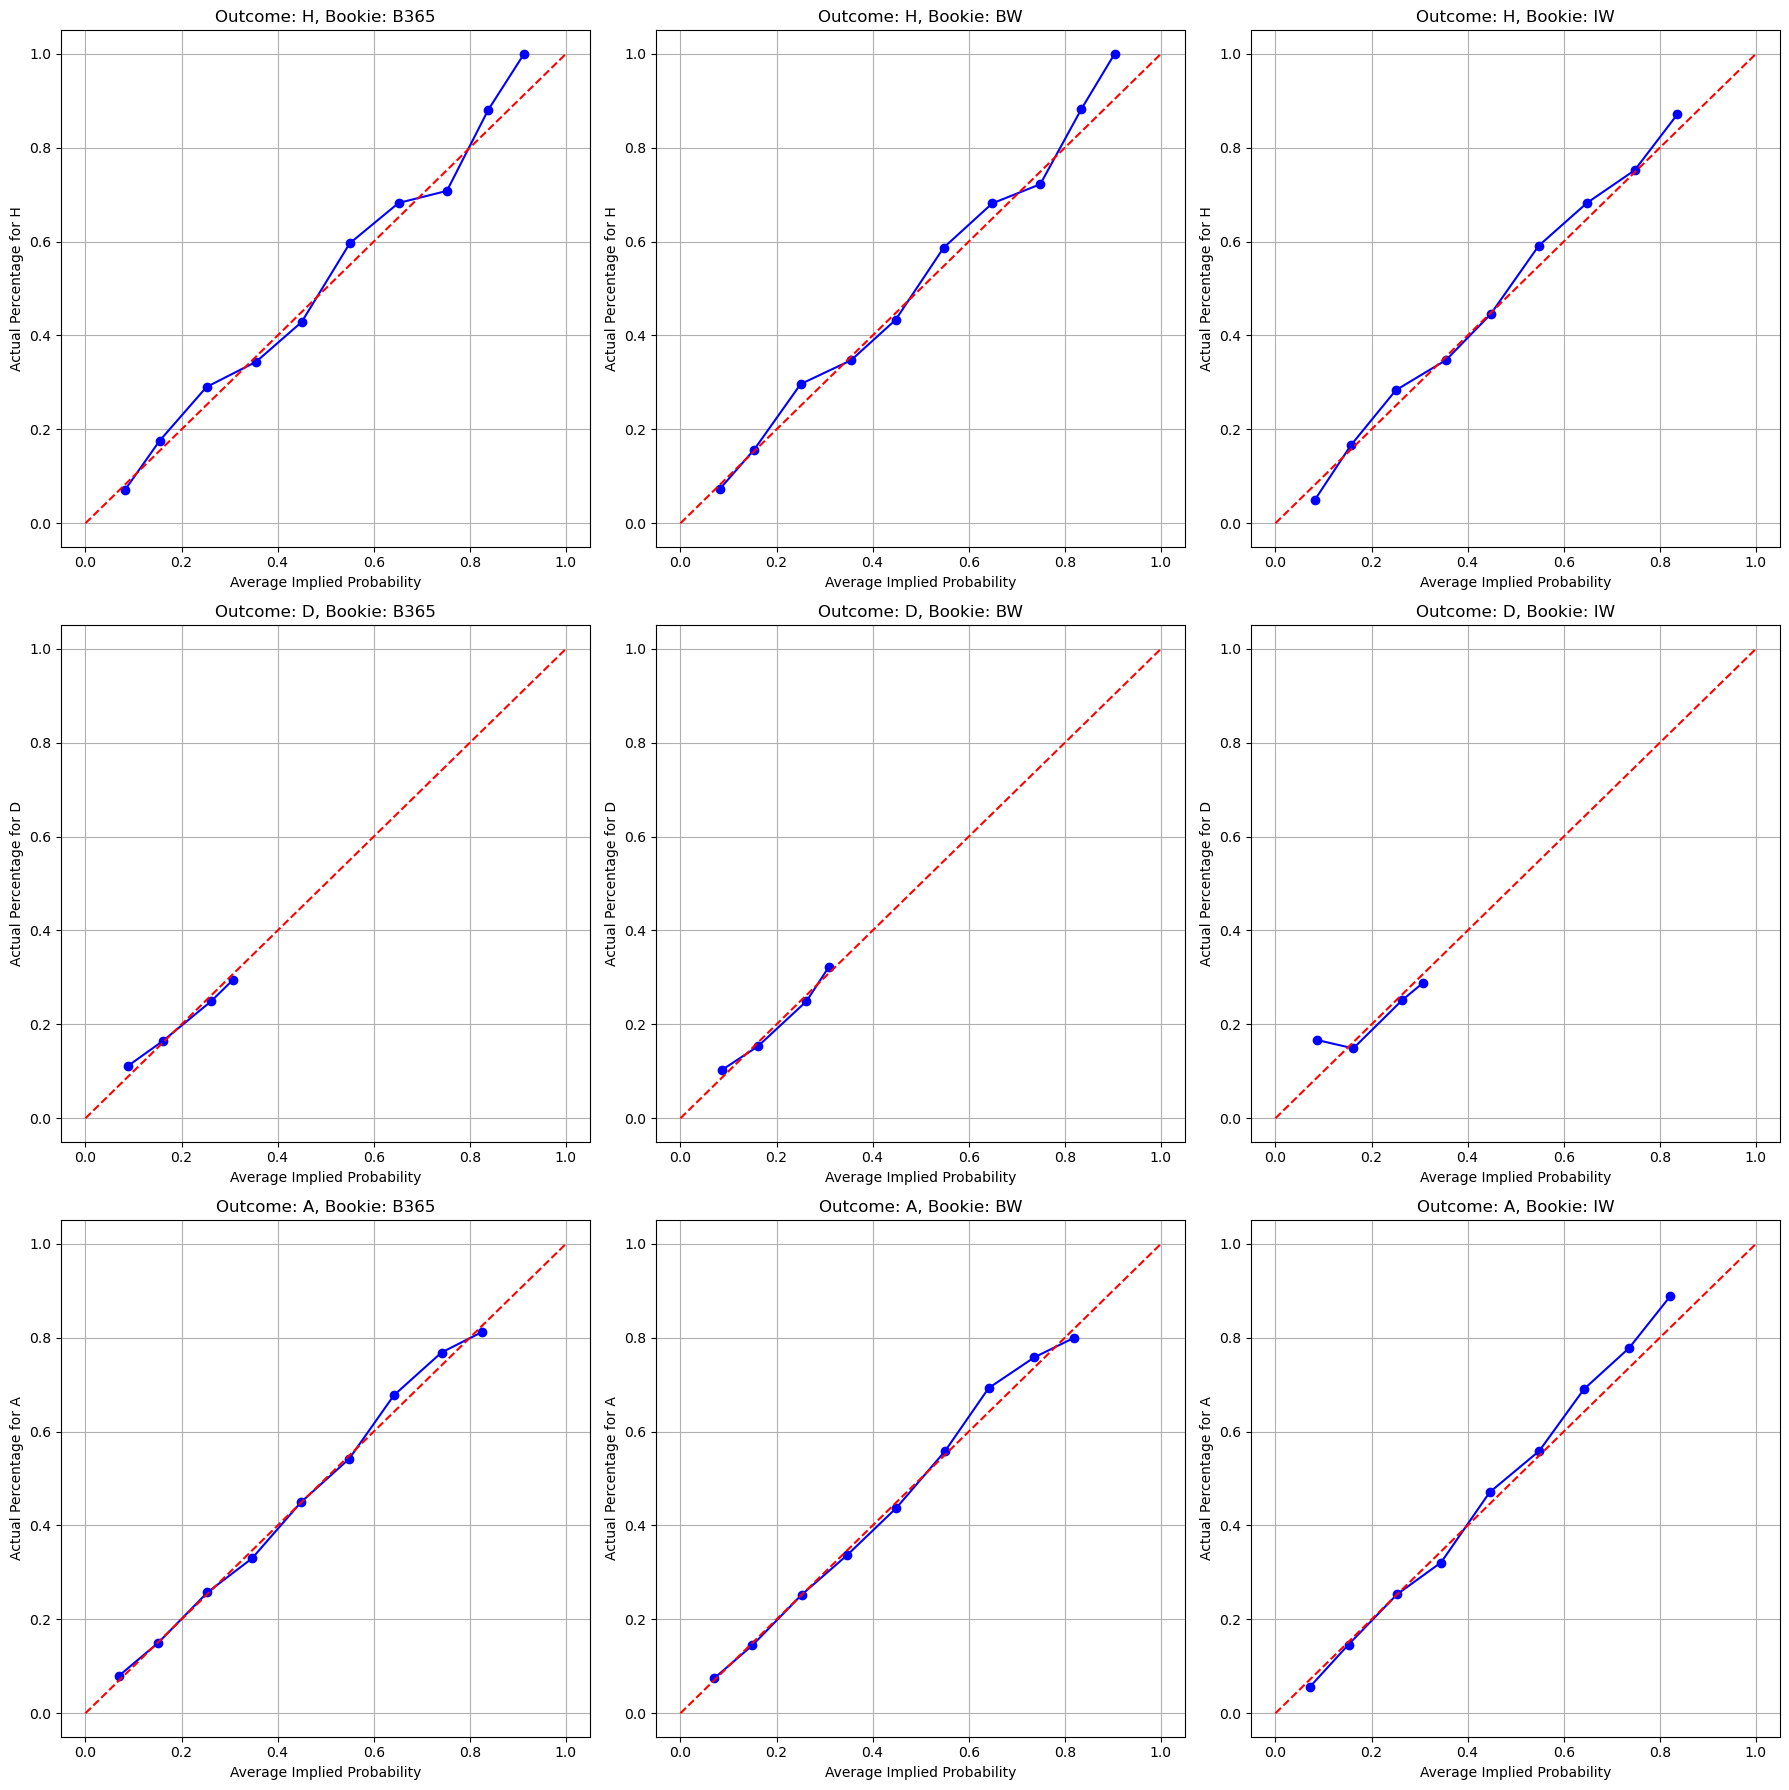

In [61]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
bookmakers = ['B365', 'BW', 'IW']
outcomes = ['H', 'D', 'A']

def get_calibration_data(bookie, outcome):
    """Function to get calibration data for a given bookie and outcome."""
    if outcome == 'H':
        prob_col = f'{bookie}H_prob'
    elif outcome == 'D':
        prob_col = f'{bookie}D_prob'
    else:
        prob_col = f'{bookie}A_prob'
        
    if prob_col not in data.columns:
        odds_col = prob_col[:-5]  # Removing the '_prob' suffix to get the odds column
    
    data['prob_bin'] = pd.cut(data[prob_col], bins=bins, labels=bin_labels, right=False)
    
    # Calculate the actual outcome percentage for each bin
    actual_percent = data.groupby('prob_bin').apply(lambda x: (x['FTR'] == outcome).mean())
    
    # Calculate the average implied probability for each bin
    average_implied_prob = data.groupby('prob_bin')[prob_col].mean()
    
    return average_implied_prob, actual_percent

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, outcome in enumerate(outcomes):
    for j, bookie in enumerate(bookmakers):
        average_implied_prob, actual_percent = get_calibration_data(bookie, outcome)
        
        # Plotting on the respective subplot
        ax = axes[i, j]
        ax.plot(average_implied_prob, actual_percent, marker='o', linestyle='-', color='blue')
        ax.plot([0, 1], [0, 1], linestyle='--', color='red')
        ax.set_title(f'Outcome: {outcome}, Bookie: {bookie}')
        ax.set_xlabel('Average Implied Probability')
        ax.set_ylabel(f'Actual Percentage for {outcome}')
        ax.grid(True)

plt.tight_layout()
plt.show()


### Generating the features 

In [37]:
elo_rating_generator = EloRatingGenerator()
win_streak_generator = WinStreakGenerator()
gap_rating_generator = GapRatingGenerator(input_features=[("FTHG", "FTAG"), ("HC", "AC")])
pi_rating_generator = PiRatingGenerator()

football_dataset.compute_features([elo_rating_generator, win_streak_generator, gap_rating_generator, pi_rating_generator])


## ROC AUC & Berier Score

In [62]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss, auc
import numpy as np

# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in implied probability columns
probability_columns = [f"{bookie}{outcome}_prob" for bookie in bookmakers for outcome in outcomes]
data.dropna(subset=probability_columns, inplace=True)

# Function to calculate ROC AUC and Brier Score for a given bookie and outcome
def evaluate_forecast(bookie, outcome):
    """Function to calculate ROC AUC and Brier Score for a given bookie and outcome."""
    # Extract the relevant implied probability column
    if outcome == 'H':
        prob_col = f'{bookie}H_prob'
    elif outcome == 'D':
        prob_col = f'{bookie}D_prob'
    else:
        prob_col = f'{bookie}A_prob'
        
    # Binarize the actual outcomes (1 if the event occurred, 0 otherwise)
    actual_outcomes = (data['FTR'] == outcome).astype(int)
    
    # Calculate ROC AUC and Brier Score
    fpr, tpr, _ = roc_curve(actual_outcomes, data[prob_col])
    roc_auc = auc(fpr, tpr)
    brier = brier_score_loss(actual_outcomes, data[prob_col])
    
    return fpr, tpr, roc_auc, brier


for bookie in bookmakers:
    for outcome in outcomes:
        odds_col = f"{bookie}{outcome}"
        prob_col = f"{odds_col}_prob"

# Compute the ROC AUC and Brier scores for each combination again
roc_aucs = {'B365': {}, 'BW': {}, 'IW': {}}
brier_scores = {'B365': {}, 'BW': {}, 'IW': {}}

for outcome in outcomes:
    for bookie in bookmakers:
        _, _, roc_auc, brier = evaluate_forecast(bookie, outcome)
        roc_aucs[bookie][outcome] = roc_auc
        brier_scores[bookie][outcome] = brier


### ROC AUC (Receiver Operating Characteristic Area Under the Curve):
The ROC AUC is a metric that evaluates the ability of a probabilistic forecast to discriminate between two classes, in this case, whether an event (e.g., a home win) occurred or not.

- Values close to 1.0 indicate excellent discriminatory ability.
- A value of 0.5 indicates no discrimination (i.e., no better than random guessing).


In [63]:
display(pd.DataFrame(roc_aucs))

,B365,BW,IW
H,0.729142,0.729490,0.728781
D,0.590193,0.591533,0.589903
A,0.739436,0.740141,0.739336


### Brier Score:
The Brier score measures the accuracy of probabilistic predictions. It quantifies the difference between the predicted probabilities and the actual outcomes.

- A Brier score of 0 indicates perfect accuracy.
- A Brier score of 0.25 for binary events would suggest a forecast no better than random guessing.

In [64]:
display(pd.DataFrame(brier_scores))

,B365,BW,IW
H,0.208211,0.208144,0.208574
D,0.176185,0.176138,0.176351
A,0.182279,0.182136,0.182347
